# 🧠 Customer Churn & Lifetime Value Prediction (Telco Dataset)

This end-to-end project forecasts customer churn and lifetime value (LTV) using XGBoost and SHAP. It covers:

- 📊 Binary classification to predict churn likelihood
- 💰 Regression modeling to estimate customer LTV
- 🧪 Best practices for leakage prevention and model explainability

**Tools & Methods:** pandas | XGBoost | SHAP | scikit-learn | seaborn | matplotlib


# 📊 Customer Churn and Lifetime Value (LTV) Modeling
A complete data science pipeline using XGBoost, SHAP, and regression techniques.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier, XGBRegressor

sns.set(style='whitegrid')


In [2]:

df = pd.read_csv('Churn.csv')
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df[df['TotalCharges'].notna()].copy()


In [4]:

df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
df['NumServices'] = (df[['PhoneService', 'MultipleLines', 'OnlineSecurity',
                         'OnlineBackup', 'DeviceProtection', 'TechSupport',
                         'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

df['TenureGroup'] = pd.cut(df['tenure'],
                           bins=[0, 12, 24, 48, 72],
                           labels=['0–12', '13–24', '25–48', '49–72'])

df['CalculatedLTV'] = df['MonthlyCharges'] * df['tenure']


In [5]:

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df_model = df.drop(columns=['customerID', 'TotalCharges'])


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:35:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81      1033
           1       0.51      0.68      0.58       374

    accuracy                           0.74      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.77      0.74      0.75      1407

🔢 ROC-AUC Score: 0.81154391704759


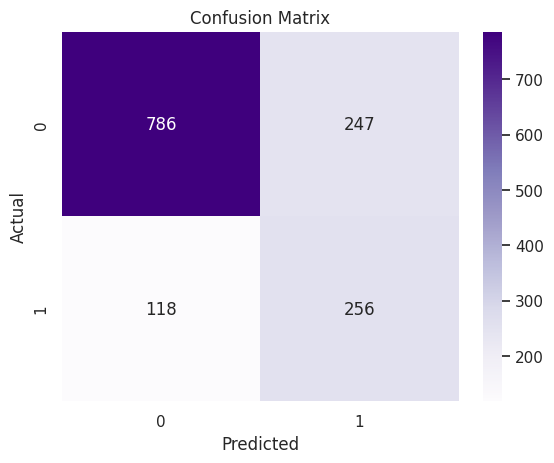

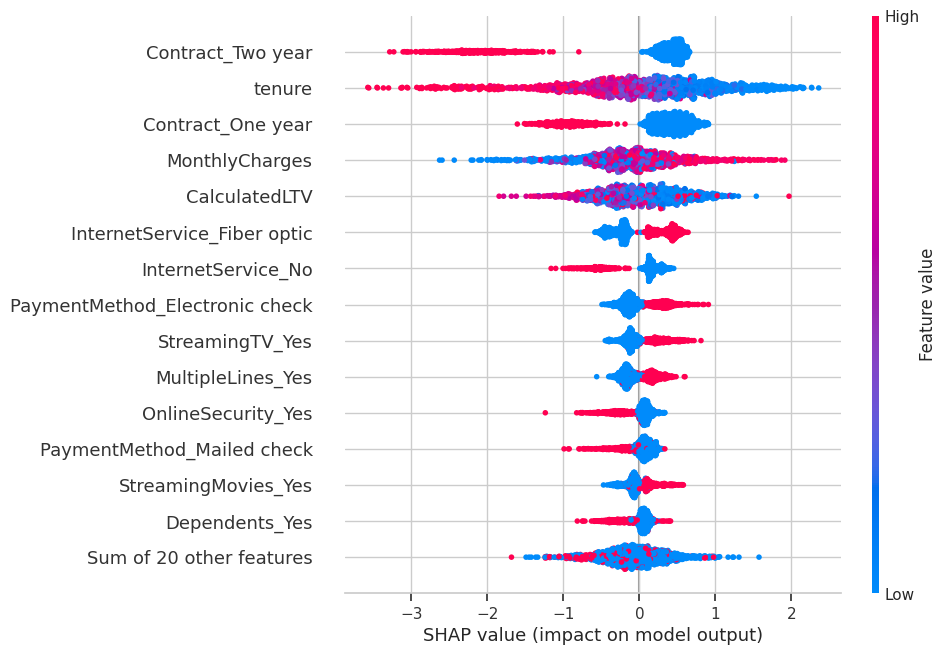

📌 Top 5 Churn Drivers:
 Contract_Two year    0.818959
tenure               0.801805
Contract_One year    0.530688
MonthlyCharges       0.478029
CalculatedLTV        0.417619
dtype: float64


In [6]:
# 1️⃣ Feature Preparation
X = df_model.drop(columns='Churn')
y = df_model['Churn']

# 2️⃣ One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# 3️⃣ Ensure all features are numeric and SHAP-compatible
X_encoded = X_encoded.astype('float64')  # Best practice for SHAP + XGBoost

# 4️⃣ Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# 5️⃣ XGBoost Classifier with class imbalance handled
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # Handle imbalance
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 6️⃣ Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("🔍 Classification Report:\n", classification_report(y_test, y_pred))
print("🔢 ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# 7️⃣ Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 8️⃣ SHAP Explainability
import shap
explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_test)

# SHAP Beeswarm Plot
shap.plots.beeswarm(shap_values, max_display=15)

# 🔝 Top 5 SHAP features
import numpy as np
mean_shap = np.abs(shap_values.values).mean(axis=0)
shap_summary = pd.Series(mean_shap, index=X_test.columns).sort_values(ascending=False)
print("📌 Top 5 Churn Drivers:\n", shap_summary.head(5))


In [7]:
# 🎯 LTV Prediction Setup
# Drop Churn to avoid leakage into LTV
X_ltv = df_model.drop(columns=['Churn', 'CalculatedLTV'])
y_ltv = df_model['CalculatedLTV']

# 📦 One-hot encode + cast to numeric
X_ltv_encoded = pd.get_dummies(X_ltv, drop_first=True).astype('float64')

# 🔀 Train-test split
from sklearn.model_selection import train_test_split
X_train_ltv, X_test_ltv, y_train_ltv, y_test_ltv = train_test_split(
    X_ltv_encoded, y_ltv, test_size=0.2, random_state=42
)

# ⚙️ Train XGBoost Regressor
from xgboost import XGBRegressor
xgb_ltv_model = XGBRegressor(random_state=42)
xgb_ltv_model.fit(X_train_ltv, y_train_ltv)

# 📈 Predict and Evaluate
y_pred_ltv = xgb_ltv_model.predict(X_test_ltv)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test_ltv, y_pred_ltv))
mae = mean_absolute_error(y_test_ltv, y_pred_ltv)
r2 = r2_score(y_test_ltv, y_pred_ltv)

print(f"📊 LTV Model Evaluation:")
print(f"🔹 RMSE: {rmse:.2f}")
print(f"🔹 MAE:  {mae:.2f}")
print(f"🔹 R²:   {r2:.2f}")


📊 LTV Model Evaluation:
🔹 RMSE: 35.80
🔹 MAE:  22.30
🔹 R²:   1.00


In [8]:
# 🎯 Define new modeling data (drop leakage variables)
X_ltv_real = df_model.drop(columns=['Churn', 'CalculatedLTV', 'tenure'])  # Drop tenure to prevent leakage
y_ltv_real = df_model['CalculatedLTV']

# 🔄 One-hot encode and cast
X_ltv_real_encoded = pd.get_dummies(X_ltv_real, drop_first=True).astype('float64')

# 🔀 Split into train/test
from sklearn.model_selection import train_test_split
X_train_ltv_real, X_test_ltv_real, y_train_ltv_real, y_test_ltv_real = train_test_split(
    X_ltv_real_encoded, y_ltv_real, test_size=0.2, random_state=42
)

# 🤖 Train model
from xgboost import XGBRegressor
xgb_ltv_real = XGBRegressor(random_state=42)
xgb_ltv_real.fit(X_train_ltv_real, y_train_ltv_real)

# 📊 Evaluate
y_pred_ltv_real = xgb_ltv_real.predict(X_test_ltv_real)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse_real = np.sqrt(mean_squared_error(y_test_ltv_real, y_pred_ltv_real))
mae_real = mean_absolute_error(y_test_ltv_real, y_pred_ltv_real)
r2_real = r2_score(y_test_ltv_real, y_pred_ltv_real)

print(f"📊 Realistic LTV Model:")
print(f"🔹 RMSE: {rmse_real:.2f}")
print(f"🔹 MAE:  {mae_real:.2f}")
print(f"🔹 R²:   {r2_real:.2f}")


📊 Realistic LTV Model:
🔹 RMSE: 440.89
🔹 MAE:  309.43
🔹 R²:   0.96
